In [ ]:
import os.path
from ast import literal_eval
from math import ceil
from typing import List, Dict, Tuple
from abc import ABC, abstractmethod
import os
import re
import joblib
import warnings
from pathlib import Path
import random
from time import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
import nlpaug.augmenter.word as naw
from tqdm.auto import tqdm
from ml_data_engine import DataProcessor, YAMLConfigParser
from sklearn.feature_extraction.text import TfidfVectorizer
from eldar import Index
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizerFast, PreTrainedTokenizer, DistilBertModel
from sklearn.metrics import classification_report
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Этап 1 - Загрузка и анализ данных

### Discipline Entities

In [ ]:
discipline_entities = pd.read_csv(
    "../data/disciplines_entities20230506.csv", header=0,
     names=["id", "title", "qualification", "raw_text", "author_entities"]
)
print(f"Объём датасета: {discipline_entities.shape[0]}")
display(discipline_entities.sample(3))

Объём датасета: 8365


,id,title,qualification,raw_text,author_entities
8028,24191,Форсайт и стратегическое планирование,master,Форсайт и стратегическое планирование. Курс по...,[Умение проводить анализ внешней и внутренней ...
4649,17799,"Этические, социальные и юридические вопросы пр...",master,"Этические, социальные и юридические вопросы пр...",[Research from the perspective of contemporary...
6841,21128,Дискретная математика (продвинутый уровень),bachelor,Дискретная математика (продвинутый уровень). Д...,[умение строить остовное дерево для заданного ...


**Выполним предобработку текста**

In [ ]:
dp = DataProcessor(YAMLConfigParser("../configs/preprocessing.yaml"))

In [ ]:
discipline_entities = dp.process_dataframe_text(discipline_entities, ["raw_text"])

In [ ]:
discipline_entities.sample(3)

,id,title,qualification,raw_text,author_entities
692,4427,Биомодификации пищевого сырья растительного и ...,bachelor,биомодификация пищевой сырье растительный живо...,[Теоретические основы технологии пищевых проду...
1211,5743,Программно-аппаратные средства,master,программно аппаратный средство рамка данный ди...,[Реализация алгоритмов взаимодействия модулей ...
8078,24276,Цифровые инструменты и метафоры,master,цифровой инструмент метафора курс посвятить пр...,"[Формулировка гипотез, Сбор информации из соци..."


In [ ]:
discipline_entities.rename(columns={"raw_text": "processed_text"}, inplace=True)

**Оставим только уникальные образцы из колонок, которыми мы будем пользоваться при обучении поиска**

In [ ]:
discipline_entities.drop_duplicates(subset=["title", "processed_text", "author_entities"], inplace=True)
print(f"Объём датасета: {discipline_entities.shape[0]}")
display(discipline_entities.sample(3))

Объём датасета: 7261


,id,title,qualification,processed_text,author_entities
7953,24097,Проектирование баз данных,master,проектирование база данные рамка изучение данн...,"['Язык структурированных запросов (SQL)', 'Тех..."
1103,5434,Языки программирования,master,язык программирование курс язык программирован...,"['Язык Python для анализа данных', 'Создание п..."
6012,19868,Обработка естественного языка,master,обработка естественный язык курс посвятить зад...,"['Программирование на Python', 'Машинное обуче..."


In [ ]:
discipline_entities.drop(columns=["qualification"], inplace=True)

In [ ]:
discipline_entities["tokenized_text"] = discipline_entities.processed_text.apply(word_tokenize)

In [ ]:
discipline_entities.to_csv("../data/discipline_entities_processed_7200.csv", sep=";", index=False, encoding="utf-8")

**Прочитаем данные**

In [ ]:
discipline_entities = pd.read_csv("../data/discipline_entities_processed_7200.csv", sep=";", encoding="utf-8")
discipline_entities.tokenized_text = discipline_entities.tokenized_text.apply(literal_eval)

**Описание датасета**

In [ ]:
discipline_entities.describe()

,id
count,7261.000000
mean,14677.982509
std,6437.140190
min,2626.000000
25%,10552.000000
50%,15503.000000
75%,19868.000000
max,25077.000000


**Параметр title**

In [ ]:
discipline_entities_duplicates_title = discipline_entities[discipline_entities.duplicated(subset="title", keep=False)]
print(f"Объём датасета: {discipline_entities_duplicates_title.shape[0]}")
display(discipline_entities_duplicates_title.head(3))

Объём датасета: 4340


,id,title,processed_text,author_entities
0,2626,Философия,философия курс философия давать целостный пред...,"['Ценности современного гуманизма', 'Системное..."
1,2627,Введение в цифровую культуру и программирование,введение цифровой культура программирование ку...,"['Цифровое образование', 'Цифровая этика', 'Те..."
2,2628,Проектирование баз данных,проектирование база данные дисциплина направит...,"['Язык структурированных запросов (SQL)', 'Хра..."


In [ ]:
discipline_entities_duplicates_title[discipline_entities_duplicates_title.title == "Философия"]

,id,title,processed_text,author_entities
0,2626,Философия,философия курс философия давать целостный пред...,"['Ценности современного гуманизма', 'Системное..."
1686,10240,Философия,философия курс философия давать целостный пред...,"['Язык тела и приоритет бессознательного', 'Кл..."
3449,15101,Философия,философия курс философия давать целостный пред...,"['Ценности современного гуманизма', 'проблема ..."
6707,23098,Философия,философия уп технология инновация реализация с...,"['Ценности современного гуманизма', 'Системное..."


**Как видно, есть дисциплины с одинаковым названием**

Но у них отличается описание и/или учебные сущности.

**Проверим количество уникальных**

In [ ]:
discipline_entities.title.nunique()

4446

**Итог по title**

На 4446 меток классов для поиска у нас есть всего 7261 запись. Необходимо будет использовать аугментацию.

**Параметр текст**

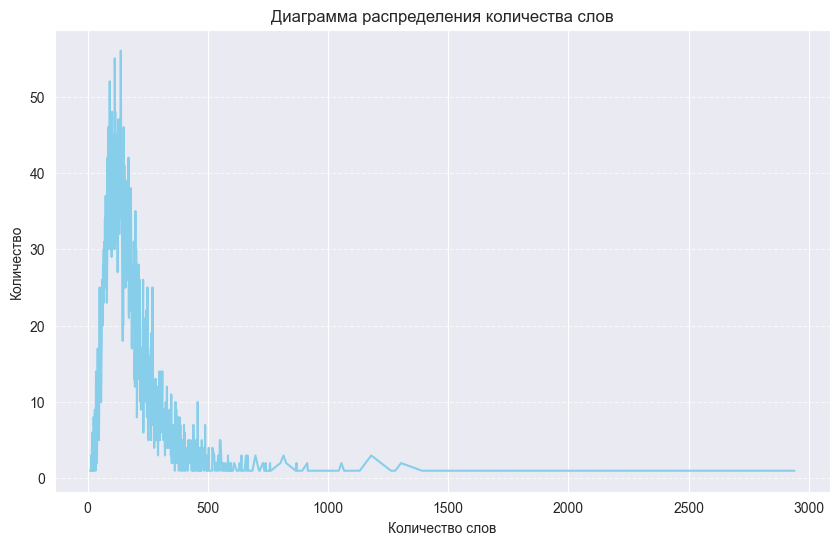

In [ ]:
discipline_entities_text_word_count = discipline_entities.copy()
discipline_entities_text_word_count["word_count"] = discipline_entities_text_word_count.tokenized_text.apply(len)

plt.figure(figsize=(10, 6))
plt.plot(discipline_entities_text_word_count.groupby(by="word_count")["id"].nunique(), color="skyblue")
plt.xlabel("Количество слов")
plt.ylabel("Количество")
plt.title("Диаграмма распределения количества слов")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

**Итог processed_text**

Наибольшее количество описаний укладывается в длину до 500 слов.

### Discipline Data

**Прочитаем данные**

In [ ]:
discipline_data = pd.read_csv("D:/Data/discipline_data_step_3.csv", sep=";", encoding="utf-8")
print(f"Объём датасета: {discipline_data.shape[0]}")
display(discipline_data.sample(3))

Объём датасета: 65910


,course_id,course_title,description,qualification,unit_id,up_id,up_title,start_year,module_name,section,topic,full_description,tokenized_description
52014,22669,Инженерный дизайн - CAD,Умение работать с 3d-моделями – это база для ш...,All_levels,42,7142,Физика и технология наноструктур / Physics and...,2021,Общеуниверситетские факультативы,Моделирование деталей Моделирование сборок Соз...,"Начало работы, создание эскизов Создание прост...",умение работать d моделями это база широкий сп...,"['умение', 'работать', 'd', 'моделями', 'это',..."
58006,22690,Актуальные поэтические практики (креативное пи...,Что такое стихотворение? Рифмованные предложен...,All_levels,9,7117,Веб-технологии,2021,Общеуниверситетские факультативы,Поэтический текст в контексте социокультурного...,Языковые основания человеческого взаимодействи...,стихотворение рифмовать предложение столбик се...,"['стихотворение', 'рифмовать', 'предложение', ..."
20727,14682,Аннотация и использование микробных геномов,Целью дисциплины является изучение:\n - Молеку...,bachelor,11,6917,Биотехнология,2019,"Специализация ""Микробные биотехнологии""",Генетический аппарат бактерий. Генетический ап...,Особенности генетического аппарата бактерий. Р...,цель дисциплина являться изучение молекулярный...,"['цель', 'дисциплина', 'являться', 'изучение',..."


**Уберём колонки, не нужные для задания**

In [ ]:
discipline_data.drop(columns=["description", "qualification", "unit_id", "up_id", "up_title",
                              "start_year", "module_name", "section", "topic"], inplace=True)

**Приведём вид датафрейма к первому**

In [ ]:
discipline_data.rename(columns={"course_id": "id",  "full_description": "processed_text",
                                "course_title": "title", "tokenized_description": "tokenized_text"}, inplace=True)

In [ ]:
discipline_data.sample(3)

,id,title,processed_text,tokenized_text
31816,15933,Специальные разделы функционального анализа,функциональный анализ появиться результат обоб...,"['функциональный', 'анализ', 'появиться', 'рез..."
37554,17725,Первичная обработка данных и Хранение больших ...,дисциплина состоять раздел раздел первичный об...,"['дисциплина', 'состоять', 'раздел', 'раздел',..."
40152,19115,Физика,первый семестр курс физика посвятить раздел ме...,"['первый', 'семестр', 'курс', 'физика', 'посвя..."


**Уберём дубликаты**

In [ ]:
discipline_data.drop_duplicates(subset=["title", "processed_text"], inplace=True)
print(f"Объём датасета: {discipline_data.shape[0]}")
display(discipline_data.sample(3))

Объём датасета: 6137


,id,title,processed_text,tokenized_text
63265,24786,"Материалы оптических, квантовых и фемтотехноло...",the discipline is focused on developing studen...,"['the', 'discipline', 'is', 'focused', 'on', '..."
39336,18448,Методы искусственного интеллекта в электроэнер...,дисциплина метод искусственный интеллект элект...,"['дисциплина', 'метод', 'искусственный', 'инте..."
19069,14054,Методы исследования региональной экономики,дисциплина метод исследование региональный эко...,"['дисциплина', 'метод', 'исследование', 'регио..."


In [ ]:
discipline_data.to_csv("../data/discipline_data_processed_6100.csv", sep=";", index=False, encoding="utf-8")

**Прочитаем данные**

In [ ]:
discipline_data = pd.read_csv("../data/discipline_data_processed_6100.csv", sep=";", encoding="utf-8")
discipline_data.tokenized_text = discipline_data.tokenized_text.apply(literal_eval)

**Описание датасета**

In [ ]:
discipline_data.describe()

,id
count,6137.000000
mean,13822.024442
std,6346.694284
min,2626.000000
25%,8171.000000
50%,14579.000000
75%,19092.000000
max,30918.000000


**Параметр title**

In [ ]:
discipline_data_duplicates_title = discipline_data[discipline_data.duplicated(subset="title", keep=False)]
print(f"Объём датасета: {discipline_data_duplicates_title.shape[0]}")
display(discipline_data_duplicates_title.head(3))

Объём датасета: 3262


,id,title,processed_text,tokenized_text
0,2626,Философия,курс философия давать целостный представление ...,"['курс', 'философия', 'давать', 'целостный', '..."
1,2627,Введение в цифровую культуру и программирование,курс введение цифровой культура программирован...,"['курс', 'введение', 'цифровой', 'культура', '..."
2,2628,Проектирование баз данных,дисциплина направить формирование понимание ос...,"['дисциплина', 'направить', 'формирование', 'п..."


In [ ]:
discipline_data_duplicates_title[discipline_data_duplicates_title.title == "Философия"]

,id,title,processed_text,tokenized_text
0,2626,Философия,курс философия давать целостный представление ...,"['курс', 'философия', 'давать', 'целостный', '..."
1633,10240,Философия,курс философия давать целостный представление ...,"['курс', 'философия', 'давать', 'целостный', '..."
3279,15101,Философия,курс философия давать целостный представление ...,"['курс', 'философия', 'давать', 'целостный', '..."


**Как видно, есть дисциплины с одинаковым названием**

Но у них отличается описание и/или учебные сущности.

**Проверим количество уникальных**

In [ ]:
discipline_data.title.nunique()

4063

**Итог по title**

На 4063 метки классов для поиска у нас есть всего 6137 запись. Необходимо будет использовать аугментацию.

**Параметр текст**

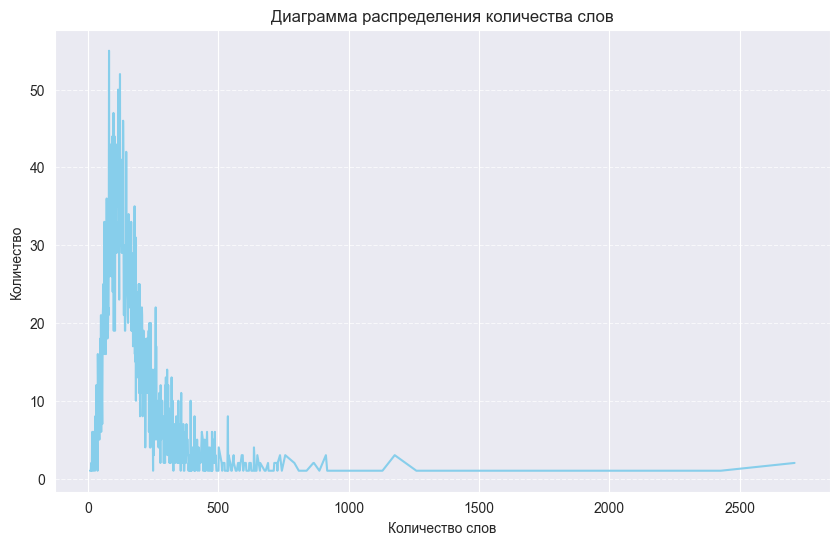

In [ ]:
discipline_data_text_word_count = discipline_data.copy()
discipline_data_text_word_count["word_count"] = discipline_data_text_word_count.tokenized_text.apply(len)

plt.figure(figsize=(10, 6))
plt.plot(discipline_data_text_word_count.groupby(by="word_count")["id"].nunique(), color="skyblue")
plt.xlabel("Количество слов")
plt.ylabel("Количество")
plt.title("Диаграмма распределения количества слов")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

**Итог processed_text**

Наибольшее количество описаний укладывается в длину до 500 слов.

## Этап 2 - Аугментация данных

**Используем библиотеку nlpaug**

Механизм ContextualWordEmbsAug, который использует transfomer модель для наиболее релевантной замены слов.

**Добавим к выборкам оригинальный текст сообщений, аугментируем его**

### Discipline Entities

In [ ]:
discipline_entities_original = pd.read_csv(
    "../data/disciplines_entities20230506.csv", header=0,
     names=["id", "title", "qualification", "raw_text", "author_entities"]
)
discipline_entities_original = discipline_entities_original[["id", "raw_text"]]
print(f"Объём датасета: {discipline_entities_original.shape[0]}")
display(discipline_entities_original.sample(3))

Объём датасета: 8365


,id,raw_text
7852,23857,Исследование альтернативных источников энергии...
5182,18561,Киберфизические системы и технологии / Cyber P...
6927,21239,Основы экономики. Дисциплина «Основы экономики...


In [ ]:
discipline_entities = pd.read_csv("../data/discipline_entities_processed_7200.csv", sep=";", encoding="utf-8")
print(f"Объём датасета: {discipline_entities.shape[0]}")
display(discipline_entities.sample(3))

Объём датасета: 7261


,id,title,processed_text,author_entities,tokenized_text
4056,17385,"Производственная, научно-исследовательская работа",производственный научно исследовательский рабо...,['Оформление результатов работы с использовани...,"['производственный', 'научно', 'исследовательс..."
2486,12588,Технологии больших данных,технология больший данные данный курс рассматр...,"['Язык R', 'Сбор данных', 'Регрессионный анали...","['технология', 'больший', 'данные', 'данный', ..."
5782,20462,Жизнь в науке: путеводитель молодого исследова...,жизнь наука путеводитель молодой исследователь...,"['Self-presentation', 'Public speaking skills'...","['жизнь', 'наука', 'путеводитель', 'молодой', ..."


In [ ]:
discipline_entities = pd.merge(discipline_entities, discipline_entities_original, on="id")
print(f"Объём датасета: {discipline_entities.shape[0]}")
display(discipline_entities.sample(3))

Объём датасета: 7261


,id,title,processed_text,author_entities,tokenized_text,raw_text
276,3312,Аналитика и исследование оптико-электронных пр...,аналитик исследование оптико электронный прибо...,['Умение исследовать параметры и характеристик...,"['аналитик', 'исследование', 'оптико', 'электр...",Аналитика и исследование оптико-электронных пр...
6504,22685,Сложная коммуникация,сложный коммуникация стратегический уровень ку...,"['Управление конфликтами', 'Токсичное общение'...","['сложный', 'коммуникация', 'стратегический', ...",Сложная коммуникация. На стратегическом уровне...
1218,5797,Основы обработки естественного языка,основа обработка естественный язык данный курс...,"['Языковые модели', 'Синтаксический анализ тек...","['основа', 'обработка', 'естественный', 'язык'...",Основы обработки естественного языка. В данном...


### Discipline Data

In [ ]:
discipline_data_full_description = pd.read_csv("D:/Data/discipline_data_step_1.csv", sep=";", encoding="utf-8")

In [ ]:
discipline_data_processed_description = pd.read_csv("D:/Data/discipline_data_step_3.csv", sep=";", encoding="utf-8")

In [ ]:
discipline_data_original = pd.DataFrame()
discipline_data_original["id"] = discipline_data_full_description.course_id
discipline_data_original["title"] = discipline_data_full_description.course_title
discipline_data_original["raw_text"] = discipline_data_full_description.full_description
discipline_data_original["processed_text"] = discipline_data_processed_description.full_description

In [ ]:
print(f"Объём датасета: {discipline_data_original.shape[0]}")
display(discipline_data_original.sample(3))

Объём датасета: 65910


,id,title,raw_text,processed_text
4495,3386,Общая электротехника,В курсе рассмотрены основные положения теории ...,курс рассмотреть основной положение теория эле...
33164,15940,Искусственный интеллект в искусстве,Курс посвящен теоретическому осмыслению искусс...,курс посвятить теоретический осмысление искусс...
11206,7258,Методы криптографии,Данный курс познакомит слушателей с основами к...,данный курс познакомить слушатель основа крипт...


In [ ]:
discipline_data_original.drop_duplicates(subset=["title", "processed_text"], inplace=True)

In [ ]:
discipline_data_original.shape

(6137, 4)

In [ ]:
discipline_data_original = discipline_data_original[["id", "raw_text"]]

In [ ]:
discipline_data = pd.read_csv("../data/discipline_data_processed_6100.csv", sep=";", encoding="utf-8")
print(f"Объём датасета: {discipline_data.shape[0]}")
display(discipline_data.sample(3))

Объём датасета: 6137


,id,title,processed_text,tokenized_text
2772,13430,Методы исследования бизнес-информационных сист...,рамка изучение второй часть дисциплина рассмат...,"['рамка', 'изучение', 'второй', 'часть', 'дисц..."
1859,10939,Компьютерная лингвистика,курс рассмотреть основной понятие компьютерный...,"['курс', 'рассмотреть', 'основной', 'понятие',..."
5211,20419,Web программирование,изучение данный курс студент изучить язык прог...,"['изучение', 'данный', 'курс', 'студент', 'изу..."


In [ ]:
discipline_data = pd.merge(discipline_data, discipline_data_original, on="id")
print(f"Объём датасета: {discipline_data.shape[0]}")
display(discipline_data.sample(3))

Объём датасета: 6137


,id,title,processed_text,tokenized_text,raw_text
5943,24516,Цифровая трансформация высокотехнологичных про...,рамка дисциплина слушатель познакомиться актуа...,"['рамка', 'дисциплина', 'слушатель', 'познаком...",В рамках дисциплины слушатели познакомятся с а...
2655,13161,Инновационные технологии бизнеса,курс инновационный технология бизнес направить...,"['курс', 'инновационный', 'технология', 'бизне...","Курс ""Инновационные технологии бизнеса"" направ..."
3310,15184,Проектирование информационных систем,цель изучение данный дисциплина являться теоре...,"['цель', 'изучение', 'данный', 'дисциплина', '...",Целью изучения данной дисциплины является теор...


**Выполним минимальную предобработку текстов для transformer модели**

Из обычного pipeline уберём лемматизацию и стоп-слова, трансформер отлично работает с такими текстами.

In [ ]:
from ml_data_engine import DataProcessor, YAMLConfigParser

In [ ]:
dp = DataProcessor(YAMLConfigParser("../configs/preprocessing_transformer.yaml"))

In [ ]:
discipline_entities["transformer_text"] = discipline_entities.raw_text.apply(dp.process_single_text)
discipline_entities.sample(3)

,id,title,processed_text,author_entities,tokenized_text,raw_text,transformer_text
300,3377,Физика,физик курс общий физика предназначить бакалавр...,"['Ядерная физика', 'Электричество', 'Магнетизм...","['физик', 'курс', 'общий', 'физика', 'предназн...",Физика. Курс общей физики предназначен для б...,физика курс общей физики предназначен для бака...
6683,23051,Управление интеллектуальной собственностью,управление интеллектуальный собственность дисц...,"['Экономика интеллектуальной собственности', '...","['управление', 'интеллектуальный', 'собственно...",Управление интеллектуальной собственностью. Ди...,управление интеллектуальной собственностью дис...
5448,19876,Системы локации,система локация курс посвятить система локация...,['Системы автоматического управления технологи...,"['система', 'локация', 'курс', 'посвятить', 'с...",Системы локации. Курс посвящен система локации...,системы локации курс посвящен система локации ...


In [ ]:
discipline_entities.to_csv("../data/discipline_entities_to_augment_7200.csv", encoding="utf-8", sep=";")

In [ ]:
discipline_data["transformer_text"] = discipline_data.raw_text.apply(dp.process_single_text)
discipline_data.sample(3)

,id,title,processed_text,tokenized_text,raw_text,transformer_text
5539,21256,Маркетинг смыслов,смысл это важный транслировать бренд человек о...,"['смысл', 'это', 'важный', 'транслировать', 'б...","Смыслы — это то, что важно транслировать не то...",смыслы это то что важно транслировать не тольк...
2305,12439,Физика термоэлектрических приборов,цель дисциплина служить ознакомление студент о...,"['цель', 'дисциплина', 'служить', 'ознакомлени...",Целью дисциплины служит ознакомление студентов...,целью дисциплины служит ознакомление студентов...
1198,5949,Квантовая теория многих тел / Many Body Quantu...,the course presents the modern methods of many...,"['the', 'course', 'presents', 'the', 'modern',...",The course presents the modern methods of many...,the course presents the modern methods of many...


In [ ]:
discipline_data.to_csv("../data/discipline_data_to_augment_7200.csv", encoding="utf-8", sep=";")

**Используем аугментацию**

Попробуем сделать так, чтобы каждый из классов содержал хотя бы по 5 примеров.

In [ ]:
AUG_MODEL = "DeepPavlov/distilrubert-small-cased-conversational"
TARGET_SAMPLES_COUNT = 5

aug = naw.ContextualWordEmbsAug(model_path=AUG_MODEL, device="cuda")

In [ ]:
augmented_discipline_entities = discipline_entities.copy()

for title in tqdm(discipline_entities.title.unique()):
    class_samples = discipline_entities[discipline_entities.title == title]
    texts_to_aug = class_samples.transformer_text.to_list()
    required_samples_count = TARGET_SAMPLES_COUNT - len(texts_to_aug)
    if required_samples_count <= 0:
        continue

    required_sample_from_each = ceil(required_samples_count / len(texts_to_aug))
    augmented_samples = []
    for text in texts_to_aug:
        augmented_samples.extend(aug.augment(text, n=required_sample_from_each))

    augmented_df = pd.DataFrame({
        "title": [title] * required_samples_count,
        "processed_text": augmented_samples[:required_samples_count]
    })
    augmented_discipline_entities = pd.concat([augmented_discipline_entities, augmented_df])

  0%|          | 0/4446 [00:00<?, ?it/s]

In [ ]:
print(augmented_discipline_entities.shape[0])
display(augmented_discipline_entities.sample(3))

22619


,id,title,processed_text,author_entities,tokenized_text,raw_text,transformer_text
0,NaN,Прием и регистрация оптического излучения,прием и регистрация оптического излучения цель...,NaN,NaN,NaN,NaN
5350,19748.0,Прикладные интеллектуальные системы,прикладной интеллектуальный система ход изучен...,"['Прикладные интеллектуальные системы', 'Предс...","['прикладной', 'интеллектуальный', 'система', ...",Прикладные интеллектуальные системы. В ходе из...,прикладные интеллектуальные системы в ходе изу...
0,NaN,Технологии разработки виртуальных лабораторий ...,технологии создания виртуальных лабораторий и ...,NaN,NaN,NaN,NaN


In [ ]:
augmented_discipline_entities.to_csv("../data/discipline_entities_augmented_22600.csv", encoding="utf-8", sep=";")

In [ ]:
augmented_discipline_data = discipline_data.copy()

for title in tqdm(discipline_data.title.unique()):
    class_samples = discipline_data[discipline_data.title == title]
    texts_to_aug = class_samples.transformer_text.to_list()
    required_samples_count = TARGET_SAMPLES_COUNT - len(texts_to_aug)
    if required_samples_count <= 0:
        continue

    required_sample_from_each = ceil(required_samples_count / len(texts_to_aug))
    augmented_samples = []
    for text in texts_to_aug:
        augmented_samples.extend(aug.augment(text, n=required_sample_from_each))

    augmented_df = pd.DataFrame({
        "title": [title] * required_samples_count,
        "processed_text": augmented_samples[:required_samples_count]
    })
    augmented_discipline_data = pd.concat([augmented_discipline_data, augmented_df])

  0%|          | 0/4063 [00:00<?, ?it/s]

In [ ]:
augmented_discipline_entities.shape

(37052, 7)

In [ ]:
augmented_discipline_data = augmented_discipline_entities.iloc[22619:]
augmented_discipline_data.head(5)

,id,title,processed_text,author_entities,tokenized_text,raw_text,transformer_text
0,NaN,Философия,курс философия даёт целостное знание о специфи...,NaN,NaN,NaN,NaN
1,NaN,Философия,курс философия даёт целостное пособие о специф...,NaN,NaN,NaN,NaN
0,NaN,Введение в цифровую культуру и программирование,курс введение в цифровую культуру и программир...,NaN,NaN,NaN,NaN
1,NaN,Введение в цифровую культуру и программирование,курс введение в цифровую культуру и технологии...,NaN,NaN,NaN,NaN
2,NaN,Введение в цифровую культуру и программирование,сегодня ученые по цифровой культуре необходимы...,NaN,NaN,NaN,NaN


In [ ]:
augmented_discipline_data = pd.concat([augmented_discipline_data, discipline_data])

In [ ]:
print(augmented_discipline_data.shape[0])
display(augmented_discipline_entities.sample(3))

20570


,id,title,processed_text,author_entities,tokenized_text,raw_text,transformer_text
0,NaN,Культурная институция в истории и современности,культурная институция в истории истории соврем...,NaN,NaN,NaN,NaN
2,NaN,Введение в микробиологию,цель изучения дисциплины состоит в формировани...,NaN,NaN,NaN,NaN
1,NaN,Проектирование средств измерений и контроля,проектирование средств измерений и контроля ди...,NaN,NaN,NaN,NaN


In [ ]:
augmented_discipline_data.to_csv("../data/discipline_data_augmented_20500.csv", encoding="utf-8", sep=";", index=False)

## Этап 3 - Подготовка данных для обучения моделей

In [ ]:
from ml_data_engine import DataProcessor, YAMLConfigParser

In [ ]:
dp = DataProcessor(YAMLConfigParser("../configs/preprocessing.yaml"))

In [ ]:
def preprocess_text(row: pd.Series) -> str:
    return dp.process_single_text(row["raw_text"]) if pd.isna(row["processed_text"]) else row["processed_text"]

def fill_author_entities(row: pd.Series) -> List[str]:
    return [] if pd.isna(row["author_entities"]) else row["author_entities"]

### Discipline Data

In [ ]:
discipline_data = pd.read_csv("../data/discipline_data_augmented_20500.csv", encoding="utf-8", sep=";")
print(discipline_data.shape[0])
display(discipline_data.sample(3))

20570


,id,title,processed_text,author_entities,tokenized_text,raw_text,transformer_text
4930,NaN,Пакеты прикладных программ,современные пакеты прикладных программ для мод...,NaN,NaN,NaN,NaN
16233,10658.0,Теория колебаний,знание типовой уравнение колебательный система...,NaN,"['знание', 'типовой', 'уравнение', 'колебатель...",Знания: типовые уравнения колебательных систем...,знания типовые уравнения колебательных систем ...
228,NaN,Визуализация и моделирование,в ходе изучения дисциплины студенты знакомятся...,NaN,NaN,NaN,NaN


In [ ]:
discipline_data.drop(columns=["id", "tokenized_text", "transformer_text", "raw_text"], inplace=True)

In [ ]:
discipline_data = dp.process_dataframe_text(discipline_data, ["processed_text"])

In [ ]:
discipline_data.author_entities = discipline_data.apply(fill_author_entities, axis=1)

In [ ]:
discipline_data.head(5)

,title,processed_text,author_entities
0,Философия,курс философия давать целостный знание специфи...,[]
1,Философия,курс философия давать целостный пособие специф...,[]
2,Введение в цифровую культуру и программирование,курс введение цифровой культура программирован...,[]
3,Введение в цифровую культуру и программирование,курс введение цифровой культура технология дав...,[]
4,Введение в цифровую культуру и программирование,сегодня ученый цифровой культура необходимый с...,[]


In [ ]:
discipline_data.to_csv("../data/discipline_data_train_20500.csv", index=False, sep=";", encoding="utf-8")

### Discipline Entities

In [ ]:
discipline_entities = pd.read_csv("../data/discipline_entities_augmented_22600.csv", encoding="utf-8", sep=";")
print(discipline_entities.shape[0])
display(discipline_entities.sample(3))

22619


,Unnamed: 0,id,title,processed_text,author_entities,tokenized_text,raw_text,transformer_text
15128,1,NaN,Современные проблемы материаловедения,современные проблемы материаловедения данный к...,NaN,NaN,NaN,NaN
12033,3,NaN,Теоретические основы системы рециклинга биосырья,теоретические основы системы рециклинга биосыр...,NaN,NaN,NaN,NaN
20234,1,NaN,Этика искусственного интеллекта,этика искусственного интеллекта искусственный ...,NaN,NaN,NaN,NaN


In [ ]:
discipline_entities.drop(columns=["Unnamed: 0", "id", "tokenized_text", "transformer_text", "raw_text"], inplace=True)

In [ ]:
discipline_entities = dp.process_dataframe_text(discipline_entities, ["processed_text"])

In [ ]:
discipline_entities.author_entities = discipline_entities.apply(fill_author_entities, axis=1)

In [ ]:
discipline_entities.head(5)

,title,processed_text,author_entities
0,Философия,философия курс философия давать целостный пред...,"['Ценности современного гуманизма', 'Системное..."
1,Введение в цифровую культуру и программирование,введение цифровой культура программирование ку...,"['Цифровое образование', 'Цифровая этика', 'Те..."
2,Проектирование баз данных,проектирование база данные дисциплина направит...,"['Язык структурированных запросов (SQL)', 'Хра..."
3,Современные вопросы информатики,современный вопрос информатика дисциплина напр...,"['Теория информации', 'Сверточные коды', 'Лине..."
4,Иностранный язык,иностранный язык цель освоение дисциплина явля...,['Типология языков']


In [ ]:
discipline_entities.to_csv("../data/discipline_entities_train_22600.csv", index=False, sep=";", encoding="utf-8")

**Создадим выборки для тестирования поисков**

In [ ]:
discipline_data = pd.read_csv("../data/discipline_data_augmented_20500.csv", sep=";", encoding="utf-8")

In [ ]:
_, discipline_data_test = train_test_split(
    discipline_data[["processed_text", "title"]], test_size=0.2,
    random_state=0, stratify=discipline_data.title
)

In [ ]:
discipline_data_test.shape

(4114, 2)

In [ ]:
discipline_data_test.to_csv("../data/discipline_data_test_4100.csv", index=False, sep=";", encoding="utf-8")

In [ ]:
discipline_entities = pd.read_csv("../data/discipline_entities_augmented_22600.csv", sep=";", encoding="utf-8")

In [ ]:
_, discipline_entities_test = train_test_split(
    discipline_entities[["processed_text", "title"]], test_size=0.2,
    random_state=0, stratify=discipline_entities.title
)

In [ ]:
discipline_entities_test.shape

(4524, 2)

In [ ]:
discipline_entities_test.to_csv("../data/discipline_entities_test_4500.csv", index=False, sep=";", encoding="utf-8")

## Этап 4 - Булев поиск

**Реализуем интерфейсы**

In [ ]:
class ISearchEngine(ABC):
    @abstractmethod
    def search_course(self, prompt: str, n: int) -> List[str]:
        """
        :param prompt: Запрос пользователя в формате, соответствующем поисковому движку.
        :param n: Количество ответов, которое нужно сформировать.
        :return: Список названий дисциплин, которые подходят под запрос.
        """

class ITestEngine(ABC):
    # accuracy, mrr top-5, mrr top 10, время ответа
    @abstractmethod
    def get_evaluation_report(self) -> Dict[str, float]:
        """
        :return: Отчёт о метриках поиска.
        """

**И метрики, нужные для оценки**

In [ ]:
def mrr_score(y_true: List[str], y_pred: List[List[str]], n: int) -> float:
    mrr_cumulative = 0.0
    for true_label, search_results in zip(y_true, y_pred):
        try:
            mrr_cumulative += 1 / (search_results[:n].index(true_label) + 1)
        except ValueError:
            pass

    return mrr_cumulative / len(y_true)

def accuracy_score(y_true: List[str], y_pred: List[List[str]]) -> float:
    correct_guesses = 0.0
    for true_label, pred_labels in zip(y_true, y_pred):
        try:
            correct_guesses += int(true_label == pred_labels[0])
        except Exception as _:
            pass

    return correct_guesses / len(y_true)

### Реализация

Для него используем библиотеку eldar. В ней реализовано создание индекса и поиск с операторами булева поиска. Сделаем обёртку.

**Обучим индексы**

In [ ]:
discipline_entities = pd.read_csv("../data/discipline_entities_train_22600.csv", sep=";", encoding="utf-8")

In [ ]:
index = Index()
index.build(discipline_entities.processed_text)
index.save("../models/discipline_entities_index.p")

In [ ]:
discipline_data = pd.read_csv("../data/discipline_data_train_20500.csv", sep=";", encoding="utf-8")

In [ ]:
index = Index()
index.build(discipline_data.processed_text)
index.save("../models/discipline_data_index.p")

**Создадим класс**

In [ ]:
class BooleanSearchEngine(ISearchEngine):
    _PREPROCESSING_CONFIG_PATH = "../configs/preprocessing.yaml"

    def __init__(self, dataset: pd.DataFrame, document_column: str, search_index_path: str):
        if document_column not in dataset.columns:
            raise ValueError("Column is not in dataset")

        if not os.path.isfile(search_index_path):
            raise FileNotFoundError("Index file not found")

        self._dataset = dataset
        self._document_column = document_column

        self._text_processor = DataProcessor(YAMLConfigParser(self._PREPROCESSING_CONFIG_PATH))
        self._search_index = Index.load(search_index_path)

    def search_course(self, prompt: str, n: int)-> List[str]:
        preprocessed_prompt = self._preprocess_prompt_text(prompt)
        search_result_ids = self._search_index.search(preprocessed_prompt, return_ids=True)
        search_results = self._dataset[self._dataset.index.isin(search_result_ids)][self._document_column]
        output_results = []

        for title in search_results:
            if len(output_results) == n:
                break

            if title in output_results:
                continue

            output_results.append(title)

        return output_results

    def _preprocess_prompt_text(self, text: str) -> str:
        pattern = r'"(.*?)"'
        processed_text = re.sub(pattern, lambda match: f'"{self._text_processor.process_single_text(match.group(1))}"', text)
        processed_text = processed_text.replace('"', "")
        return processed_text

In [ ]:
b = BooleanSearchEngine(discipline_data, "title", "../models/discipline_data_index.p")

In [ ]:
b.search_course('"философия" AND NOT "системы"', 5)

философия AND NOT система


['Философия',
 'История искусств',
 'Введение в цифровые гуманитарные исследования',
 'Специальные разделы линейной алгебры',
 'Мышление (Основные проблемы современного политического мышления)']

**Итог**

Разработали функциональный булев поиск, попробуем его протестировать.

### Тестирование

Тестирование такого вида поиска затруднено сложностью расстановки тегов поиска адекватно.

Проверим его на случайных данных. Берём 5 токенов из самого сэмпла + 2 из другого случайного через NOT.

Очевидно, такой тест не является релевантным, лишь оценочно-пристрелочным. Без паттерна поведения пользователя тестирование практически невозможно.

In [ ]:
class BooleanTestEngine(ITestEngine):
    def __init__(self, dataset: pd.DataFrame, document_column: str, terms_column: str, search_engine: BooleanSearchEngine):
        if not any(column in dataset.columns for column in [terms_column, document_column]):
            raise ValueError("Columns are not in dataset")

        self._dataset = dataset
        self._document_column = document_column
        self._terms_column = terms_column
        self._search_engine = search_engine

        self._test_samples = self._create_test_samples()

    def get_evaluation_report(self) -> Dict[str, float]:
        PREDICTION_COUNT = 10
        y_true = []
        y_pred = []
        start_time = time()
        for true_label, prompt in self._test_samples:
            try:
                y_pred.append(self._search_engine.search_course(prompt, PREDICTION_COUNT))
                y_true.append(true_label)
            except Exception as _:
                pass

        execution_time = time() - start_time

        return {
            "execution_time": execution_time,
            "accuracy": accuracy_score(y_true, y_pred),
            "mrr_5": mrr_score(y_true, y_pred, 5),
            "mrr_10": mrr_score(y_true, y_pred, 10)
        }

    def _create_test_samples(self) -> List[Tuple[str, str]]:
        CORRECT_TERMS = 5
        INCORRECT_TERMS = 2
        test_samples = []
        for _, row in self._dataset.iterrows():
            terms = row[self._terms_column].split()
            random.shuffle(terms)
            prepared_terms = [f'"{term}"' for term in terms[:CORRECT_TERMS]]

            other_row_id = random.randint(0, self._dataset.shape[0] - 1)
            other_terms = self._dataset.iloc[other_row_id][self._terms_column].split()
            not_terms = random.sample(other_terms, INCORRECT_TERMS)
            not_prepared_terms = [f'NOT "{term}"' for term in not_terms]

            prepared_terms += not_prepared_terms
            test_samples.append((row[self._document_column], " AND ".join(prepared_terms)))

        return test_samples

**Discipline Data**

In [ ]:
discipline_data = pd.read_csv("../data/discipline_data_train_20500.csv", sep=";", encoding="utf-8")
discipline_data_test = pd.read_csv("../data/discipline_data_test_4100.csv", sep=";", encoding="utf-8")

In [ ]:
boolean_search_discipline_data = BooleanSearchEngine(discipline_data, "title", "../models/discipline_data_index.p")
boolean_test_discipline_data = BooleanTestEngine(discipline_data_test, "title", "processed_text", boolean_search_discipline_data)

In [ ]:
boolean_test_discipline_data.get_evaluation_report()

{'execution_time': 41.715678691864014,
 'accuracy': 0.3661248930710009,
 'mrr_5': 0.42733818078129526,
 'mrr_10': 0.4296222181487371}

**Discipline Entities**

In [ ]:
discipline_entities = pd.read_csv("../data/discipline_entities_train_22600.csv", sep=";", encoding="utf-8")
discipline_entities_test = pd.read_csv("../data/discipline_entities_test_4500.csv", sep=";", encoding="utf-8")

In [ ]:
boolean_search_discipline_entities = BooleanSearchEngine(discipline_entities, "title", "../models/discipline_entities_index.p")
boolean_test_discipline_entities = BooleanTestEngine(discipline_entities_test, "title", "processed_text", boolean_search_discipline_entities)

In [ ]:
boolean_test_discipline_entities.get_evaluation_report()

{'execution_time': 50.58664560317993,
 'accuracy': 0.34533183352080987,
 'mrr_5': 0.40436195475565617,
 'mrr_10': 0.4071011956838733}

**Итог**

Хорошая скорость работы - ~90 запросов в секунду, качество трудно оценить объективно, умозрительно нормальное, относительно запросов.

## Этап 5 - Tfidf Search

**Реализация**

Составим словари терминов, обучим tfidf из scikit-learn.

**Discipline Entities**

In [ ]:
discipline_entities = pd.read_csv("../data/discipline_entities_train_22600.csv", sep=";", encoding="utf-8")

In [ ]:
discipline_entities["tokenized_text"] = discipline_entities.processed_text.str.split()

In [ ]:
discipline_entities_vocabulary = set()
for _, row in discipline_entities.iterrows():
    discipline_entities_vocabulary.update(row["tokenized_text"])

In [ ]:
discipline_entities_vocabulary = list(discipline_entities_vocabulary)
print(len(discipline_entities_vocabulary))
print(discipline_entities_vocabulary[0:5])

39365
['окуляры', 'records', 'flowering', 'кардиоидный', 'научтиться']


In [ ]:
tfidf_discipline_entities = TfidfVectorizer(vocabulary=discipline_entities_vocabulary, lowercase=False)
tfidf_discipline_entities.fit(discipline_entities.processed_text)
joblib.dump(tfidf_discipline_entities, "../models/discipline_entities_tfidf.pkl")

**Discipline Data**

In [ ]:
discipline_data = pd.read_csv("../data/discipline_data_train_20500.csv", sep=";", encoding="utf-8")

In [ ]:
discipline_data["tokenized_text"] = discipline_data.processed_text.str.split()

In [ ]:
discipline_data_vocabulary = set()
for _, row in discipline_data.iterrows():
    discipline_data_vocabulary.update(row["tokenized_text"])

In [ ]:
discipline_data_vocabulary = list(discipline_data_vocabulary)
print(len(discipline_data_vocabulary))
print(discipline_data_vocabulary[0:5])

38258
['вибраторы', 'окуляры', 'records', 'flowering', 'кардиоидный']


In [ ]:
tfidf_discipline_data = TfidfVectorizer(vocabulary=discipline_data_vocabulary, lowercase=False)
tfidf_discipline_data.fit(discipline_data.processed_text)
joblib.dump(tfidf_discipline_data, "../models/discipline_data_tfidf.pkl")

['../models/discipline_data_tfidf.pkl']

**Напишем класс, реализующий метод**

In [ ]:
class TfidfSearchEngine(ISearchEngine):
    _PREPROCESSING_CONFIG_PATH = "../configs/preprocessing.yaml"

    def __init__(self, dataset: pd.DataFrame, document_column: str, terms_column: str):
        if not any(column in dataset.columns for column in [terms_column, document_column]):
            raise ValueError("Columns are not in dataset")

        self._dataset = dataset
        self._document_column = document_column
        self._terms_column = terms_column

        self._text_processor = DataProcessor(YAMLConfigParser(self._PREPROCESSING_CONFIG_PATH))

        self._vocabulary = self._generate_vocabulary()
        self._tfidf_model = TfidfVectorizer(vocabulary=self._vocabulary, lowercase=False)
        self._tfidf_model.fit(self._dataset[self._terms_column])
        self._matrix = self._tfidf_model.transform(self._dataset[self._terms_column])

    def search_course(self, prompt: str, n: int)-> List[str]:
        preprocessed_prompt = self._preprocess_prompt_text(prompt)
        prompt_vector = self._generate_prompt_vector(preprocessed_prompt)

        documents_cosine_similarities = [self._cosine_similarity(prompt_vector, document) for document in self._matrix.A]
        output_ids = np.array(documents_cosine_similarities).argsort()[::-1]

        output_results = []

        for identifier in output_ids:
            title = self._dataset.iloc[identifier][self._document_column]
            if len(output_results) == n:
                break

            if title in output_results:
                continue

            output_results.append(title)

        return output_results

    def _generate_vocabulary(self) -> List[str]:
        vocabulary = set()
        for _, row in self._dataset.iterrows():
            vocabulary.update(row[self._terms_column].split())

        return list(vocabulary)

    def _preprocess_prompt_text(self, text: str) -> str:
        return self._text_processor.process_single_text(text)

    def _generate_prompt_vector(self, text: str) -> np.ndarray:
        vector = np.zeros((len(self._vocabulary)))
        matrix = self._tfidf_model.transform([text])
        for token in text.split():
            try:
                index = self._vocabulary.index(token)
                vector[index]  = matrix[0, self._tfidf_model.vocabulary_[token]]
            except ValueError as _:
                pass

        return vector

    @staticmethod
    def _cosine_similarity(a: np.ndarray, b: np.ndarray) -> float:
        return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

In [ ]:
test = TfidfSearchEngine(discipline_entities, "title", "processed_text")

In [ ]:
test.search_course("философия", 5)

['Философская антропология и социальная философия / Philosophical Anthropology and Social Philosophy',
 'Философия и научная методология в дизайне',
 'Теория феминизма, вводный курс',
 'Философия',
 'История и философия науки']

**Итог**

Разработали функциональный tfidf поиск, попробуем его протестировать.

### Тестирование

Проверим его на случайных данных. Берём 7 токенов из самого сэмпла.

Очевидно, такой тест не является релевантным, лишь оценочно-пристрелочным. Без паттерна поведения пользователя тестирование практически невозможно.

In [ ]:
class TfidfTestEngine(ITestEngine):
    def __init__(self, dataset: pd.DataFrame, document_column: str, terms_column: str, search_engine: TfidfSearchEngine):
        if not any(column in dataset.columns for column in [terms_column, document_column]):
            raise ValueError("Columns are not in dataset")

        self._dataset = dataset
        self._document_column = document_column
        self._terms_column = terms_column
        self._search_engine = search_engine

        self._test_samples = self._create_test_samples()

    def get_evaluation_report(self) -> Dict[str, float]:
        PREDICTION_COUNT = 10
        y_true = []
        y_pred = []
        start_time = time()
        for true_label, prompt in self._test_samples:
            try:
                y_pred.append(self._search_engine.search_course(prompt, PREDICTION_COUNT))
                y_true.append(true_label)
            except Exception as _:
                pass

        execution_time = time() - start_time

        return {
            "execution_time": execution_time,
            "accuracy": accuracy_score(y_true, y_pred),
            "mrr_5": mrr_score(y_true, y_pred, 5),
            "mrr_10": mrr_score(y_true, y_pred, 10)
        }

    def _create_test_samples(self) -> List[Tuple[str, str]]:
        SAMPLES_COUNT = 100
        CORRECT_TERMS = 7
        test_samples = []
        for _, row in self._dataset.iterrows():
            terms = row[self._terms_column].split()
            random.shuffle(terms)
            test_samples.append((row[self._document_column], " ".join(terms[:CORRECT_TERMS])))

        return test_samples[:SAMPLES_COUNT]

**Discipline Data**

In [ ]:
discipline_data = pd.read_csv("../data/discipline_data_train_20500.csv", sep=";", encoding="utf-8")
discipline_data_test = pd.read_csv("../data/discipline_data_test_4100.csv", sep=";", encoding="utf-8")

In [ ]:
tfidf_search_discipline_data = TfidfSearchEngine(discipline_data, "title", "processed_text")
tfidf_test_discipline_data = TfidfTestEngine(discipline_data_test, "title", "processed_text", tfidf_search_discipline_data)

In [ ]:
tfidf_test_discipline_data.get_evaluation_report()

{'execution_time': 256.91877007484436,
 'accuracy': 0.55,
 'mrr_5': 0.6565000000000001,
 'mrr_10': 0.6611507936507937}

**Discipline Entities**

In [ ]:
discipline_entities = pd.read_csv("../data/discipline_entities_train_22600.csv", sep=";", encoding="utf-8")
discipline_entities_test = pd.read_csv("../data/discipline_entities_test_4500.csv", sep=";", encoding="utf-8")

In [ ]:
tfidf_search_discipline_entities = TfidfSearchEngine(discipline_entities, "title", "processed_text")
tfidf_test_discipline_entities = TfidfTestEngine(discipline_entities_test, "title", "processed_text", tfidf_search_discipline_entities)

In [ ]:
tfidf_test_discipline_entities.get_evaluation_report()

{'execution_time': 298.73387241363525,
 'accuracy': 0.38,
 'mrr_5': 0.5248333333333335,
 'mrr_10': 0.5396746031746034}

**Итог**

Скорость значительно хуже, чем у булева поиска - 2,5-3с на запрос. Из-за этого пришлось урезать тестовую выборку, поэтому её репрезентативность оставляет желать лучшего. Умозрительно кажется, что качество возросло.

## Этап 6 - Transformer

**Подготовим данные**

Необходимо, чтобы метки классов были типа int.

In [ ]:
discipline_data = pd.read_csv("../data/discipline_data_train_20500.csv", sep=";", encoding="utf-8")
discipline_data.sample(3)

,title,processed_text,author_entities
7412,Основы организации международных научных иссле...,international research management of irme is a...,[]
1368,Основы композиции,курс основа композиция студент демонстрировать...,[]
10945,Диджитализация R&D-процессов,рамка работа рассматриваться основной принцип ...,[]


In [ ]:
discipline_data_mapping_dict = {name: i for i, name in enumerate(discipline_data.title.unique())}

In [ ]:
discipline_data_mapping_dict["Основы композиции"]

418

In [ ]:
discipline_data["title_id"] = discipline_data.title.map(discipline_data_mapping_dict)

In [ ]:
discipline_entities = pd.read_csv("../data/discipline_entities_train_22600.csv", sep=";", encoding="utf-8")
discipline_entities.sample(3)

,title,processed_text,author_entities
13982,Тестирование мобильных человеко-ориентированны...,тестирование мобильный человеко ориентировать ...,[]
11403,Интеллектуальные системы в управлении социальн...,интеллектуальный система управление социальный...,[]
8767,Оптика плазмы,оптика плазма курс даваться понятие основный м...,[]


In [ ]:
discipline_entities_mapping_dict = {name: i for i, name in enumerate(discipline_entities.title.unique())}

In [ ]:
discipline_entities_mapping_dict["Оптика плазмы"]

548

In [ ]:
discipline_entities["title_id"] = discipline_entities.title.map(discipline_entities_mapping_dict)

**Напишем класс датасета, методы для обучения и тестирования**

In [ ]:
class TransformerDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __getitem__(self, index):
        text = str(self.data.processed_text.iloc[index])
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs["input_ids"]
        mask = inputs["attention_mask"]

        return {
            "ids": torch.tensor(ids, dtype=torch.long),
            "mask": torch.tensor(mask, dtype=torch.long),
            "targets": torch.tensor(self.data.title_id.iloc[index], dtype=torch.long)
        }

    def __len__(self):
        return self.data.shape[0]

In [ ]:
def train_val_split(data: pd.DataFrame, batch_size: int, tokenizer: PreTrainedTokenizer,
                    max_len: int = 512) -> Tuple[DataLoader, DataLoader]:
    train_data, val_data = train_test_split(
        data[["processed_text", "title_id"]], test_size=0.2, random_state=0, stratify=data.title_id
    )

    train_dataset = TransformerDataset(train_data, tokenizer, max_len)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    val_dataset = TransformerDataset(val_data, tokenizer, max_len)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    print(f"Объём train: {len(train_loader)},\n"
          f"Объём validation: {len(val_loader)}")

    return train_loader, val_loader

def train_val_model(model: nn.Module,
                    train_loader: DataLoader,
                    val_loader: DataLoader,
                    criterion: nn.CrossEntropyLoss,
                    optimizer: optim.Adam,
                    epochs: int,
                    save_model_path: Path) -> Tuple[np.array, np.array]:

    train_losses = np.array([])
    val_losses = np.array([])

    for epoch in tqdm(range(epochs)):
        model.train()
        running_loss = 0
        for batch in train_loader:
            inputs, masks, labels = batch["ids"], batch["mask"], batch["targets"]
            inputs, masks, labels = inputs.to(device), masks.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs, masks)
            loss = criterion(outputs, labels.view(-1))
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses = np.append(train_losses, train_loss)

        model.eval()
        running_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                inputs, masks, labels = batch["ids"], batch["mask"], batch["targets"]
                inputs, masks, labels = inputs.to(device), masks.to(device), labels.to(device)
                outputs = model(inputs, masks)
                loss = criterion(outputs, labels.view(-1))
                running_loss += loss.item()

        val_loss = running_loss / len(val_loader)
        if val_losses.size == 0 or np.min(val_losses) >= val_loss:
            torch.save(model.state_dict(), save_model_path)

        val_losses = np.append(val_losses, val_loss)

        print(f"Epoch {epoch + 1}/{epochs}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    return train_losses, val_losses

def plot_train_val_loss(train_losses: np.array, val_losses: np.array) -> None:
    epochs = range(1, len(train_losses) + 1)

    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Train/Val Loss by Epochs")
    plt.legend()
    plt.show()

def test_model(model: nn.Module,
               test_loader: DataLoader,
               criterion: nn.CrossEntropyLoss) -> Tuple[np.array, np.array]:

    test_loss = 0
    y_true = np.array([])
    y_pred = np.array([])

    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            inputs, masks, labels = batch["ids"], batch["mask"], batch["targets"]
            inputs, masks, labels = inputs.to(device), masks.to(device), labels.to(device)
            outputs = model(inputs, masks)
            loss = criterion(outputs, labels.view(-1))
            test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            y_true = np.append(y_true, labels.cpu().numpy())
            y_pred = np.append(y_pred, predicted.cpu().numpy())

        avg_test_loss = test_loss / len(test_loader)
        print(f"Test Loss: {avg_test_loss:.4f}")
        return y_true, y_pred

def format_predicted_class_df(y_true: np.array, y_pred: np.array, mapping_dict: Dict[str, int]) -> pd.DataFrame:
    predicted_class = pd.DataFrame()

    predicted_class["it_service_id_true"] = y_true
    predicted_class.it_service_id_true = predicted_class.it_service_id_true.map({v: k for k, v in mapping_dict.items()})

    predicted_class["it_service_id_pred"] = y_pred
    predicted_class.it_service_id_pred = predicted_class.it_service_id_pred.map({v: k for k, v in mapping_dict.items()})

    return predicted_class

**Инициализируем токенайзер, гиперпараметры**

In [ ]:
tokenizer = DistilBertTokenizerFast.from_pretrained("DeepPavlov/distilrubert-small-cased-conversational")

In [ ]:
BATCH_SIZE = 4
NUM_LABELS_DISCIPLINE_DATA = len(discipline_data_mapping_dict)
NUM_LABELS_DISCIPLINE_ENTITIES = len(discipline_entities_mapping_dict)
LEARNING_RATE = 10 ** -5
NUM_EPOCHS = 5
INPUT_SIZE = 768
HIDDEN_SIZE = 768
DROPOUT = 0.4

**Разобьём данные на train / val**

Не будем использовать test, т.к. из-за большого количества мелких классов он должен быть большого объёма. Протестируем на валидационной выборке после обучения.

In [ ]:
train_loader_data, val_loader_data = train_val_split(discipline_data, BATCH_SIZE, tokenizer)

Объём train: 4114,
Объём validation: 1029


In [ ]:
train_loader_entities, val_loader_entities = train_val_split(discipline_entities, BATCH_SIZE, tokenizer)

Объём train: 4524,
Объём validation: 1131


**Напишем класс трансформера**

In [ ]:
class DistilBertClassifier(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, output_size: int, dropout: float):
        super(DistilBertClassifier, self).__init__()
        self.transformer = DistilBertModel.from_pretrained("DeepPavlov/distilrubert-small-cased-conversational")
        self.pre_classifier = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, input_ids, attention_mask):
        out = self.transformer(input_ids=input_ids, attention_mask=attention_mask)
        out = out[0][:, 0]
        out = self.pre_classifier(out)
        out = self.relu(out)
        out = self.dropout(out)
        return self.fc(out)

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
model_data = DistilBertClassifier(INPUT_SIZE, HIDDEN_SIZE, NUM_LABELS_DISCIPLINE_DATA, DROPOUT).to(device)
optimizer_data = optim.Adam(model_data.parameters(), lr=LEARNING_RATE)

In [ ]:
save_model_path = Path("../models/26032024_data.pth")

train_losses, val_losses = train_val_model(
    model_data, train_loader_data, val_loader_data, criterion,
    optimizer_data, NUM_EPOCHS, save_model_path)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5: Train Loss: 8.1651, Val Loss: 7.3609
Epoch 2/5: Train Loss: 6.3315, Val Loss: 4.9047
Epoch 3/5: Train Loss: 4.1953, Val Loss: 2.9716
Epoch 4/5: Train Loss: 2.7233, Val Loss: 1.7755
Epoch 5/5: Train Loss: 1.8536, Val Loss: 1.1187


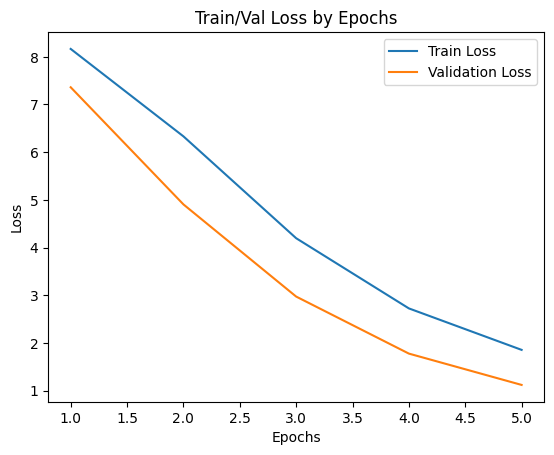

In [ ]:
plot_train_val_loss(train_losses, val_losses)

In [ ]:
load_model_path = Path("../models/26032024_data.pth")

model_data = DistilBertClassifier(INPUT_SIZE, HIDDEN_SIZE, NUM_LABELS_DISCIPLINE_DATA, DROPOUT).to(device)
model_data.load_state_dict(torch.load(load_model_path))

<All keys matched successfully>

In [ ]:
y_test_data, y_pred_data = test_model(model_data, val_loader_data, criterion)

Test Loss: 1.1187


In [ ]:
report_data = classification_report(y_test_data, y_pred_data)
print(report_data)

```
accuracy     |      |      | 0.84 | 4114

macro avg    | 0.77 | 0.84 | 0.79 | 4114

weighted avg | 0.77 | 0.84 | 0.79 | 4114
```

In [ ]:
model_entities = DistilBertClassifier(INPUT_SIZE, HIDDEN_SIZE, NUM_LABELS_DISCIPLINE_ENTITIES, DROPOUT).to(device)
optimizer_entities = optim.Adam(model_entities.parameters(), lr=LEARNING_RATE)

In [ ]:
save_model_path = Path("../models/26032024_entities.pth")

train_losses_entities, val_losses_entities = train_val_model(
    model_entities, train_loader_entities, val_loader_entities, criterion,
    optimizer_entities, NUM_EPOCHS, save_model_path)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5: Train Loss: 8.2584, Val Loss: 7.4521
Epoch 2/5: Train Loss: 6.3229, Val Loss: 4.7390
Epoch 3/5: Train Loss: 3.9434, Val Loss: 2.6399
Epoch 4/5: Train Loss: 2.4311, Val Loss: 1.5160
Epoch 5/5: Train Loss: 1.5971, Val Loss: 0.9458


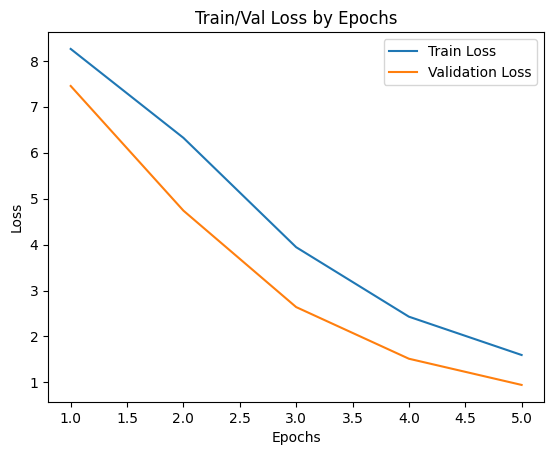

In [ ]:
plot_train_val_loss(train_losses_entities, val_losses_entities)

In [ ]:
load_model_path = Path("../models/26032024_entities.pth")

model_entities = DistilBertClassifier(INPUT_SIZE, HIDDEN_SIZE, NUM_LABELS_DISCIPLINE_ENTITIES, DROPOUT).to(device)
model_entities.load_state_dict(torch.load(load_model_path))

<All keys matched successfully>

In [ ]:
y_test_entities, y_pred_entities = test_model(model_entities, val_loader_entities, criterion)

Test Loss: 0.9458


In [ ]:
report_data_entities = classification_report(y_test_entities, y_pred_entities)
print(report_data_entities)

```
accuracy     |      |      | 0.85 | 4524
macro avg    | 0.79 | 0.85 | 0.81 | 4524
weighted avg | 0.78 | 0.85 | 0.80 | 4524
```

**Итог**

Получили отличное качество по accuracy у моделей. К сожалению, из-за нехватки времени я недообучил модель, это видно по графикам.

**Напишем класс поиска**

In [ ]:
class TransformerSearchEngine(ISearchEngine):
    _PREPROCESSING_CONFIG_PATH = "../configs/preprocessing.yaml"
    _TOKENIZER_MAX_LEN = 512
    _MODEL_NAME = "DeepPavlov/distilrubert-small-cased-conversational"
    _INPUT_SIZE = 768
    _HIDDEN_SIZE = 768
    _DROPOUT = 0.4

    def __init__(self, dataset: pd.DataFrame, document_column: str, model_path: str):
        if document_column not in dataset.columns:
            raise ValueError("Column is not in dataset")

        if not os.path.isfile(model_path):
            raise FileNotFoundError("Model file not found")

        self._dataset = dataset
        self._document_column = document_column

        self._text_processor = DataProcessor(YAMLConfigParser(self._PREPROCESSING_CONFIG_PATH))
        self._mapping_dict = {name: i for i, name in enumerate(self._dataset[self._document_column].unique())}

        self._tokenizer = DistilBertTokenizerFast.from_pretrained(self._MODEL_NAME)
        self._model = DistilBertClassifier(self._INPUT_SIZE, self._HIDDEN_SIZE, len(self._mapping_dict), self._DROPOUT).to(device)
        self._model.load_state_dict(torch.load(model_path))
        self._model.eval()

    def search_course(self, prompt: str, n: int)-> List[str]:
        preprocessed_prompt = self._preprocess_prompt_text(prompt)
        predict_df = pd.DataFrame.from_dict({"processed_text": [preprocessed_prompt], "title_id": [0]})
        predict_dataset = TransformerDataset(predict_df, self._tokenizer, self._TOKENIZER_MAX_LEN)
        predict_dataloader = DataLoader(predict_dataset, shuffle=False)
        with torch.no_grad():
            _, batch = next(enumerate(predict_dataloader))
            inputs, masks = batch["ids"], batch["mask"]
            inputs, masks = inputs.to(device), masks.to(device)
            outputs = self._model(inputs, masks)
            confidence, predicted = torch.topk(outputs, k=n, dim=1)

        predicted_classes, confidence_scores = predicted.cpu().numpy()[0], confidence.cpu().numpy()[0]
        results = [(
            list(self._mapping_dict.keys())[list(self._mapping_dict.values()).index(predicted_class)],
            confidence_score
        ) for predicted_class, confidence_score in zip(predicted_classes, confidence_scores)]
        return [item[0] for item in sorted(results, key=lambda t: t[1])[:n]]

    def _preprocess_prompt_text(self, text: str) -> str:
        return self._text_processor.process_single_text(text)

In [ ]:
discipline_entities = pd.read_csv("../data/discipline_entities_train_22600.csv", sep=";", encoding="utf-8")

In [ ]:
test = TransformerSearchEngine(discipline_entities, "title", "../models/26032024_entities.pth")

In [ ]:
test.search_course("Тестирование мобильных человеко-ориентированных систем", 5)

['Актуальные вопросы информационных систем (часть 2) / Complementary Topics in the Area Information Systems (part 2)',
 'Проектирование пользовательских интерфейсов',
 'Управление разработкой agile',
 'Управление разработкой программного обеспечения',
 'Управление разработкой']

**Итог**

Получили функциональный поиск с transformer, попробуем протестировать его.

### Тестирование

In [ ]:
class TransformerTestEngine(ITestEngine):
    def __init__(self, dataset: pd.DataFrame, document_column: str, terms_column: str, search_engine: TransformerSearchEngine):
        if not any(column in dataset.columns for column in [terms_column, document_column]):
            raise ValueError("Columns are not in dataset")

        self._dataset = dataset
        self._document_column = document_column
        self._terms_column = terms_column
        self._search_engine = search_engine

        self._test_samples = self._create_test_samples()

    def get_evaluation_report(self) -> Dict[str, float]:
        PREDICTION_COUNT = 10
        y_true = []
        y_pred = []
        start_time = time()
        for true_label, prompt in self._test_samples:
            try:
                y_pred.append(self._search_engine.search_course(prompt, PREDICTION_COUNT))
                y_true.append(true_label)
            except Exception as _:
                pass

        execution_time = time() - start_time

        return {
            "execution_time": execution_time,
            "accuracy": accuracy_score(y_true, y_pred),
            "mrr_5": mrr_score(y_true, y_pred, 5),
            "mrr_10": mrr_score(y_true, y_pred, 10)
        }

    def _create_test_samples(self) -> List[Tuple[str, str]]:
        CORRECT_TERMS_RATIO = 0.1
        test_samples = []
        for _, row in self._dataset.iterrows():
            terms = row[self._terms_column].split()
            target_len = int(len(terms) *CORRECT_TERMS_RATIO)
            test_samples.append((row[self._document_column], " ".join(terms[:target_len])))

        return test_samples

**Discipline Data**

In [ ]:
discipline_data = pd.read_csv("../data/discipline_data_train_20500.csv", sep=";", encoding="utf-8")
discipline_data_test = pd.read_csv("../data/discipline_data_test_4100.csv", sep=";", encoding="utf-8")

In [ ]:
transformer_search_discipline_data = TransformerSearchEngine(discipline_data, "title", "../models/26032024_data.pth")
transformer_test_discipline_data = TransformerTestEngine(discipline_data_test, "title", "processed_text", transformer_search_discipline_data)

In [ ]:
transformer_test_discipline_data.get_evaluation_report()

{'execution_time': 30.23901915550232,
 'accuracy': 0.009722897423432183,
 'mrr_5': 0.02448549667801005,
 'mrr_10': 0.03968012824964687}

In [ ]:
transformer_search_discipline_data.search_course("web development php javascript php building key application based program components или javascript mysql json data работа файла бд php сама работа ar dom основные типичные триггеры", 5)

['Веб-технологии',
 'Разработка веб-приложений',
 'Web-программирование',
 'Разработка графических веб-приложений',
 'Компонентное веб программирование / Component web programming']

In [ ]:
transformer_search_discipline_data.search_course("web development", 5)

['Учебная, ознакомительная',
 'Научно-исследовательская работа',
 'Разработка виртуальных лабораторий и тренажеров',
 'Научно-исследовательская работа / Research Internship',
 'Анализ и оценка пользовательского опыта']

**Discipline Entities**

In [ ]:
discipline_entities = pd.read_csv("../data/discipline_entities_train_22600.csv", sep=";", encoding="utf-8")
discipline_entities_test = pd.read_csv("../data/discipline_entities_test_4500.csv", sep=";", encoding="utf-8")

In [ ]:
transformer_search_discipline_entities = TransformerSearchEngine(discipline_entities, "title", "../models/26032024_entities.pth")
transformer_test_discipline_entities = TransformerTestEngine(discipline_entities_test, "title", "processed_text", transformer_search_discipline_entities)

In [ ]:
transformer_test_discipline_entities.get_evaluation_report()

{'execution_time': 34.25285315513611,
 'accuracy': 0.01237842617152962,
 'mrr_5': 0.03470748600058945,
 'mrr_10': 0.06068586585827936}

**Итог**

Получили отличную скорость благодаря работе на GPU. На CPU будет просадка в 50-100 раз.
Качество поиска при выдаче полного теста было отличное, точность ~0.85, но при выдаче лишь части промпта, что является приближённым к сценарию использования, качество сильно падает и становится заметно хуже, чем у конкурентов.

## Итоги по поиску

Отобразим в виде датафрейма.

In [ ]:
pd.DataFrame.from_dict({
    "name": ["boolean_data", "boolean_entities", "tfidf_data", "tfidf_entities",
             "transformer_data_test", "transformer_data", "transformer_entities_test", "transformer_entities"],
    "execution_time_per_sample": [0.01, 0.011, 2.56, 2.98, pd.NA, 0.007, pd.NA, 0.007],
    "accuracy": [0.366, 0.345, 0.55, 0.38, 0.84, 0.097, 0.85, 0.012],
    "mrr_5": [0.427, 0.404, 0.656, 0.524, pd.NA, 0.024, pd.NA, 0.034],
    "mrr_10": [0.429, 0.407, 0.661, 0.539, pd.NA, 0.039, pd.NA, 0.060]
})

,name,execution_time_per_sample,accuracy,mrr_5,mrr_10
0,boolean_data,0.01,0.366,0.427,0.429
1,boolean_entities,0.011,0.345,0.404,0.407
2,tfidf_data,2.56,0.550,0.656,0.661
3,tfidf_entities,2.98,0.380,0.524,0.539
4,transformer_data_test,<NA>,0.840,<NA>,<NA>
5,transformer_data,0.007,0.097,0.024,0.039
6,transformer_entities_test,<NA>,0.850,<NA>,<NA>
7,transformer_entities,0.007,0.012,0.034,0.06


## Этап 7 - Генерация учебных сущностей по описанию

Для генерации воспользуемся ChatGPT 3.5, сравнивать будем, векторизовав текущие данные с помощью sentence-transformer.

**Используем следующий prompt**

<img src="../reports/gpt.png">

In [ ]:
discipline_entities = pd.read_csv(
    "../data/disciplines_entities20230506.csv", header=0,
     names=["id", "title", "qualification", "raw_text", "author_entities"]
)
discipline_entities.author_entities = discipline_entities.author_entities.apply(literal_eval)
print(f"Объём датасета: {discipline_entities.shape[0]}")
display(discipline_entities.sample(3))

Объём датасета: 8365


,id,title,qualification,raw_text,author_entities
3667,15257,Физическое материаловедение,bachelor,Физическое материаловедение. Образовательная п...,"[Фазовые диаграммы в сплавах, Рентгенографичес..."
1960,10865,Smart Grid,bachelor,"Smart Grid. В данной дисциплине, рассматривают...",[Моделирование технических систем]
2247,11840,Проектирование и анализ языков веб-решений,master,Проектирование и анализ языков веб-решений. Ди...,"[Язык программирования JavaScript, Язык XML и ..."


In [ ]:
discipline_entities.sample(3)

,id,title,qualification,raw_text,author_entities
1892,10615,Методы оптимизации,bachelor,Методы оптимизации. Дисциплина направлена на м...,"[Регуляризация, Методы оптимизации, Методы опт..."
5478,18977,Математический анализ,bachelor,Математический анализ. Математический анализ -...,[Умение применять методы математического анали...
317,3408,Тепловые процессы машин и аппаратов,bachelor,Тепловые процессы машин и аппаратов. В ходе из...,"[Термоэлектрические охладители, Термодинамичес..."


In [ ]:
entities_to_generate = discipline_entities.sample(10)
entities_to_generate

,id,title,qualification,raw_text,author_entities
7027,21389,Основы светотехники и физиологической оптики,master,Основы светотехники и физиологической оптики. ...,"[Фотометрические величины, Первичная обработка..."
459,3893,Управление инновационными стартапами,bachelor,Управление инновационными стартапами. Дисципли...,"[Управление инновационными стартапами, Стартап..."
2501,12517,Перспективы направления применения криогенных ...,master,Перспективы направления применения криогенных ...,[Перспективы направления применения криогенных...
8128,24359,Research Seminar / Научно-исследовательский се...,master,Research Seminar / Научно-исследовательский се...,[Hypothesis formulation of the research work]
5863,19647,Моделирование технических систем,bachelor,Моделирование технических систем. Дисциплина н...,"[Хаос, Устойчивость систем управления, Устойчи..."
7135,22242,Продвинутое МО (Python) и Автоматическая обраб...,master,Продвинутое МО (Python) и Автоматическая обраб...,"[Zipf's Law, Vector semantics, TF*IDF Model, T..."
912,4911,Технологии производства радиоэлектронной аппар...,master,Технологии производства радиоэлектронной аппар...,[Электрический монтаж кристаллов интегральных ...
8347,24945,Математические модели низкоразмерных систем,master,Математические модели низкоразмерных систем. К...,"[Низкоразмерные системы, Математическое модели..."
3672,15264,Электродинамика и кристаллооптика,bachelor,Электродинамика и кристаллооптика. В результат...,"[Энергия магнитостатического поля, Электростат..."
1153,5567,Технологии продвижения интернет-проектов,master,Технологии продвижения интернет-проектов. Эта ...,"[Структура медийной рекламы, Способы получения..."


In [ ]:
entities_to_generate.to_csv("../data/entities_to_generate.csv", index=False, sep=";", encoding="utf-8")

In [ ]:
generated_entities = [
        ['Основы светотехники', 'Физиологическая оптика', 'Фотометрические величины', 'Стандарты освещения', 'Взаимодействие света с веществом'],
        ['Управление инновационными стартапами', 'Бизнес-модель стартапа', 'Стадии разработки стартапа', 'Проектный подход к управлению стартапом', 'Зарубежный опыт управления стартапом'],
        ['Криогенные системы', 'Криогенные технологии', 'Криохирургия', 'Сверхпроводимость', 'Сжижение воздуха'],
        ['Научно-исследовательский семинар', 'Разработка научной работы', 'Представление результатов исследования', 'Выбор темы исследования', 'Формулирование гипотезы'],
        ['Моделирование технических систем', 'Дискретные системы управления', 'Искусственные нейронные сети', 'Линейные системы управления', 'Нелинейные системы управления'],
        ['Продвинутое МО (Python)', 'Автоматическая обработка текстов', 'Метод главных компонент (PCA)', 'Метод опорных векторов (SVM)', 'Решающие деревья', 'Ансамбли моделей', 'Обучение с подкреплением', 'Информационный поиск', 'Классификация текстов', 'Лексические ресурсы', 'Семантическое моделирование', 'Вычислительный синтаксис'],
        ['Технологии производства радиоэлектронной аппаратуры', 'Микроэлектроника', 'Полупроводниковые структуры', 'Интегральные микросхемы', 'Печатные платы', 'Многослойные печатные платы', 'Нанотехнологии', 'Методы контроля печатных плат', 'Тонкоплёночные интегральные схемы', 'Электрический монтаж кристаллов интегральных схем', 'Сборка и монтаж печатных плат'],
        ['Математические модели низкоразмерных систем', 'Методы моделирования низкоразмерных систем', 'Низкоразмерные системы', 'Современные методы исследования низкоразмерных структур', 'Новые эффекты в наносистемах'],
        ['Электродинамика и кристаллооптика', 'Математические модели', 'Электродинамика', 'Кристаллооптика', 'Уравнения Максвелла'],
        ['Технологии продвижения интернет-проектов', 'Машинное обучение', 'Оптимизация контента', 'UX/UI оптимизация', 'Методы продвижения в вебе']
]

In [ ]:
entities_to_generate["generated_entities"] = generated_entities

In [ ]:
entities_to_generate

,id,title,qualification,raw_text,author_entities,generated_entities
7027,21389,Основы светотехники и физиологической оптики,master,Основы светотехники и физиологической оптики. ...,"[Фотометрические величины, Первичная обработка...","[Основы светотехники, Физиологическая оптика, ..."
459,3893,Управление инновационными стартапами,bachelor,Управление инновационными стартапами. Дисципли...,"[Управление инновационными стартапами, Стартап...","[Управление инновационными стартапами, Бизнес-..."
2501,12517,Перспективы направления применения криогенных ...,master,Перспективы направления применения криогенных ...,[Перспективы направления применения криогенных...,"[Криогенные системы, Криогенные технологии, Кр..."
8128,24359,Research Seminar / Научно-исследовательский се...,master,Research Seminar / Научно-исследовательский се...,[Hypothesis formulation of the research work],"[Научно-исследовательский семинар, Разработка ..."
5863,19647,Моделирование технических систем,bachelor,Моделирование технических систем. Дисциплина н...,"[Хаос, Устойчивость систем управления, Устойчи...","[Моделирование технических систем, Дискретные ..."
7135,22242,Продвинутое МО (Python) и Автоматическая обраб...,master,Продвинутое МО (Python) и Автоматическая обраб...,"[Zipf's Law, Vector semantics, TF*IDF Model, T...","[Продвинутое МО (Python), Автоматическая обраб..."
912,4911,Технологии производства радиоэлектронной аппар...,master,Технологии производства радиоэлектронной аппар...,[Электрический монтаж кристаллов интегральных ...,[Технологии производства радиоэлектронной аппа...
8347,24945,Математические модели низкоразмерных систем,master,Математические модели низкоразмерных систем. К...,"[Низкоразмерные системы, Математическое модели...","[Математические модели низкоразмерных систем, ..."
3672,15264,Электродинамика и кристаллооптика,bachelor,Электродинамика и кристаллооптика. В результат...,"[Энергия магнитостатического поля, Электростат...","[Электродинамика и кристаллооптика, Математиче..."
1153,5567,Технологии продвижения интернет-проектов,master,Технологии продвижения интернет-проектов. Эта ...,"[Структура медийной рекламы, Способы получения...","[Технологии продвижения интернет-проектов, Маш..."


In [ ]:
entities_to_generate.to_csv("../data/entities_to_generate.csv", index=False, sep=";", encoding="utf-8")

**Составим средний вектор дисциплин**

In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer("distiluse-base-multilingual-cased-v1")

In [ ]:
data_processor = DataProcessor(YAMLConfigParser("../configs/preprocessing_transformer.yaml"))

In [ ]:
def get_mean_vector(items: List[str]) -> List[float]:
    item_vectors = np.array([model.encode(data_processor.process_single_text(sentence)) for sentence in items])
    return np.mean(item_vectors, axis=0).tolist()

In [ ]:
print(get_mean_vector(["привет", "мир"])[:5])
print(get_mean_vector(["привет"])[:5])
print(get_mean_vector(["мир"])[:5])

[0.014169921167194843, -0.011107522062957287, -0.038068972527980804, -0.0010716104879975319, -0.04602693393826485]
[0.0038178390823304653, -0.005090594757348299, -0.019723830744624138, 0.011065121740102768, -0.015065954998135567]
[0.024522002786397934, -0.017124449834227562, -0.05641411617398262, -0.013208342716097832, -0.07698791474103928]


In [ ]:
entities_to_generate["author_mean_vector"] = entities_to_generate.author_entities.apply(get_mean_vector)
entities_to_generate["generated_mean_vector"] = entities_to_generate.generated_entities.apply(get_mean_vector)

In [ ]:
entities_to_generate

,id,title,qualification,raw_text,author_entities,generated_entities,author_mean_vector,generated_mean_vector
7027,21389,Основы светотехники и физиологической оптики,master,Основы светотехники и физиологической оптики. ...,"[Фотометрические величины, Первичная обработка...","[Основы светотехники, Физиологическая оптика, ...","[-0.013136726804077625, 0.026863034814596176, ...","[-0.013628440909087658, 0.020255792886018753, ..."
459,3893,Управление инновационными стартапами,bachelor,Управление инновационными стартапами. Дисципли...,"[Управление инновационными стартапами, Стартап...","[Управление инновационными стартапами, Бизнес-...","[0.011342816054821014, -0.0013189356541261077,...","[0.024528514593839645, 0.009194690734148026, 0..."
2501,12517,Перспективы направления применения криогенных ...,master,Перспективы направления применения криогенных ...,[Перспективы направления применения криогенных...,"[Криогенные системы, Криогенные технологии, Кр...","[0.030943678691983223, -0.006771647837013006, ...","[-0.022648930549621582, 0.005444146692752838, ..."
8128,24359,Research Seminar / Научно-исследовательский се...,master,Research Seminar / Научно-исследовательский се...,[Hypothesis formulation of the research work],"[Научно-исследовательский семинар, Разработка ...","[0.024553649127483368, 0.0555807426571846, 0.0...","[-0.027276661247015, 0.0496349036693573, 0.010..."
5863,19647,Моделирование технических систем,bachelor,Моделирование технических систем. Дисциплина н...,"[Хаос, Устойчивость систем управления, Устойчи...","[Моделирование технических систем, Дискретные ...","[0.008502312935888767, 0.02092849090695381, 0....","[0.00010108724382007495, 0.002031441079452634,..."
7135,22242,Продвинутое МО (Python) и Автоматическая обраб...,master,Продвинутое МО (Python) и Автоматическая обраб...,"[Zipf's Law, Vector semantics, TF*IDF Model, T...","[Продвинутое МО (Python), Автоматическая обраб...","[-0.014860865660011768, 0.00885345321148634, -...","[-0.02926650643348694, 0.027800356969237328, 0..."
912,4911,Технологии производства радиоэлектронной аппар...,master,Технологии производства радиоэлектронной аппар...,[Электрический монтаж кристаллов интегральных ...,[Технологии производства радиоэлектронной аппа...,"[-0.018292363733053207, -0.003311171429231763,...","[-0.011741843074560165, -0.01805954985320568, ..."
8347,24945,Математические модели низкоразмерных систем,master,Математические модели низкоразмерных систем. К...,"[Низкоразмерные системы, Математическое модели...","[Математические модели низкоразмерных систем, ...","[0.012918466702103615, 0.0016160309314727783, ...","[-0.004665915854275227, 0.0023530079051852226,..."
3672,15264,Электродинамика и кристаллооптика,bachelor,Электродинамика и кристаллооптика. В результат...,"[Энергия магнитостатического поля, Электростат...","[Электродинамика и кристаллооптика, Математиче...","[-0.010775228962302208, 0.011773093603551388, ...","[-0.015098698437213898, 0.01643996313214302, -..."
1153,5567,Технологии продвижения интернет-проектов,master,Технологии продвижения интернет-проектов. Эта ...,"[Структура медийной рекламы, Способы получения...","[Технологии продвижения интернет-проектов, Маш...","[-0.03085930459201336, 0.020093094557523727, -...","[-0.06111132353544235, 0.04358988255262375, 0...."


In [ ]:
entities_to_generate.to_csv("../data/entities_to_generate_vectorized.csv", index=False, sep=";", encoding="utf-8")

**Напишем метод для оценки близости**

In [ ]:
def get_cosine_similarity(row: pd.Series) -> float:
    return cosine_similarity([row["author_mean_vector"]], [row["generated_mean_vector"]])[0][0]

In [ ]:
entities_to_generate["cosine_similarity"] = entities_to_generate.apply(get_cosine_similarity, axis=1)

In [ ]:
entities_to_generate.to_csv("../data/entities_to_generate_cosine.csv", index=False, sep=";", encoding="utf-8")

In [ ]:
entities_to_generate

,id,title,qualification,raw_text,author_entities,generated_entities,author_mean_vector,generated_mean_vector,cosine_similarity
7027,21389,Основы светотехники и физиологической оптики,master,Основы светотехники и физиологической оптики. ...,"[Фотометрические величины, Первичная обработка...","[Основы светотехники, Физиологическая оптика, ...","[-0.013136726804077625, 0.026863034814596176, ...","[-0.013628440909087658, 0.020255792886018753, ...",0.640509
459,3893,Управление инновационными стартапами,bachelor,Управление инновационными стартапами. Дисципли...,"[Управление инновационными стартапами, Стартап...","[Управление инновационными стартапами, Бизнес-...","[0.011342816054821014, -0.0013189356541261077,...","[0.024528514593839645, 0.009194690734148026, 0...",0.556544
2501,12517,Перспективы направления применения криогенных ...,master,Перспективы направления применения криогенных ...,[Перспективы направления применения криогенных...,"[Криогенные системы, Криогенные технологии, Кр...","[0.030943678691983223, -0.006771647837013006, ...","[-0.022648930549621582, 0.005444146692752838, ...",0.280636
8128,24359,Research Seminar / Научно-исследовательский се...,master,Research Seminar / Научно-исследовательский се...,[Hypothesis formulation of the research work],"[Научно-исследовательский семинар, Разработка ...","[0.024553649127483368, 0.0555807426571846, 0.0...","[-0.027276661247015, 0.0496349036693573, 0.010...",0.762013
5863,19647,Моделирование технических систем,bachelor,Моделирование технических систем. Дисциплина н...,"[Хаос, Устойчивость систем управления, Устойчи...","[Моделирование технических систем, Дискретные ...","[0.008502312935888767, 0.02092849090695381, 0....","[0.00010108724382007495, 0.002031441079452634,...",0.533783
7135,22242,Продвинутое МО (Python) и Автоматическая обраб...,master,Продвинутое МО (Python) и Автоматическая обраб...,"[Zipf's Law, Vector semantics, TF*IDF Model, T...","[Продвинутое МО (Python), Автоматическая обраб...","[-0.014860865660011768, 0.00885345321148634, -...","[-0.02926650643348694, 0.027800356969237328, 0...",0.798968
912,4911,Технологии производства радиоэлектронной аппар...,master,Технологии производства радиоэлектронной аппар...,[Электрический монтаж кристаллов интегральных ...,[Технологии производства радиоэлектронной аппа...,"[-0.018292363733053207, -0.003311171429231763,...","[-0.011741843074560165, -0.01805954985320568, ...",0.920695
8347,24945,Математические модели низкоразмерных систем,master,Математические модели низкоразмерных систем. К...,"[Низкоразмерные системы, Математическое модели...","[Математические модели низкоразмерных систем, ...","[0.012918466702103615, 0.0016160309314727783, ...","[-0.004665915854275227, 0.0023530079051852226,...",0.693762
3672,15264,Электродинамика и кристаллооптика,bachelor,Электродинамика и кристаллооптика. В результат...,"[Энергия магнитостатического поля, Электростат...","[Электродинамика и кристаллооптика, Математиче...","[-0.010775228962302208, 0.011773093603551388, ...","[-0.015098698437213898, 0.01643996313214302, -...",0.751677
1153,5567,Технологии продвижения интернет-проектов,master,Технологии продвижения интернет-проектов. Эта ...,"[Структура медийной рекламы, Способы получения...","[Технологии продвижения интернет-проектов, Маш...","[-0.03085930459201336, 0.020093094557523727, -...","[-0.06111132353544235, 0.04358988255262375, 0....",0.711621


**Оценим результаты**

In [ ]:
entities_to_generate.cosine_similarity.describe()

count    10.000000
mean      0.665021
std       0.176562
min       0.280636
25%       0.577535
50%       0.702691
75%       0.759429
max       0.920695
Name: cosine_similarity, dtype: float64

**Итог**

Получили весьма хорошие результаты, средняя близость 0.67, что очень хорошо, с учётом того, что фактически дообучение не проводилось.

Стоит учитывать, что выборка маленькая, поэтому не слишком репрезентативная.